# Installation

## Install in local Python environment (where jupyter notebook is started):

```
python -m pip install ipywidgets pandas
```

## Install in Slicer Python environment (by running the cell below):

In [ ]:
# There are no official pyzmq wheels for Python-3.6 for Windows, so we have to install manually
import os
if os.name=='nt':
    pip_install("https://files.pythonhosted.org/packages/94/e1/13059383d21444caa16306b48c8bf7a62331ca361d553d2119696ea67119/pyzmq-19.0.0-cp36-cp36m-win_amd64.whl")

pip_install("ipywidgets pandas")
pip_install("itkwidgets==0.27.2")

# Interactive volume rendering
The entire view layout or selected widgets can be displayed in a notebook cell. Views can be shown using interactive widgets (slice scrolling, view rotation).
Rendering happens server-side, in Slicer, which can run on the cloud, on a container. Source data does not have to be sent to the user's computer.

In [ ]:
# Import ITK widgets
from ipywidgets import interact
import matplotlib
matplotlib.use('Agg')
import SimpleITK as sitk
import sitkUtils as su
from itkwidgets import view

In [ ]:
# Get a volume
slicer.mrmlScene.Clear()
import SampleData
volume=SampleData.SampleDataLogic().downloadCTACardio()

# Enable 3D volume rendering
slicer.nb.showVolumeRendering(volume)

slicer.nb.displayViews("FourUp")

In [ ]:
# Interactive 3D view
@interact(roll=(-90.0,90.0,5), pitch=(-90.0,90.0,5), yaw=(-180.0,180.0,5))
def update(roll=0, pitch=0, yaw=0):
    return slicer.nb.display3DView(0, orientation=[roll, pitch, yaw])

In [ ]:
image=su.PullVolumeFromSlicer(volume)
view(image, vmin=-200, vmax=1700, gradient_opacity=0.2)

# Segmentation visualization

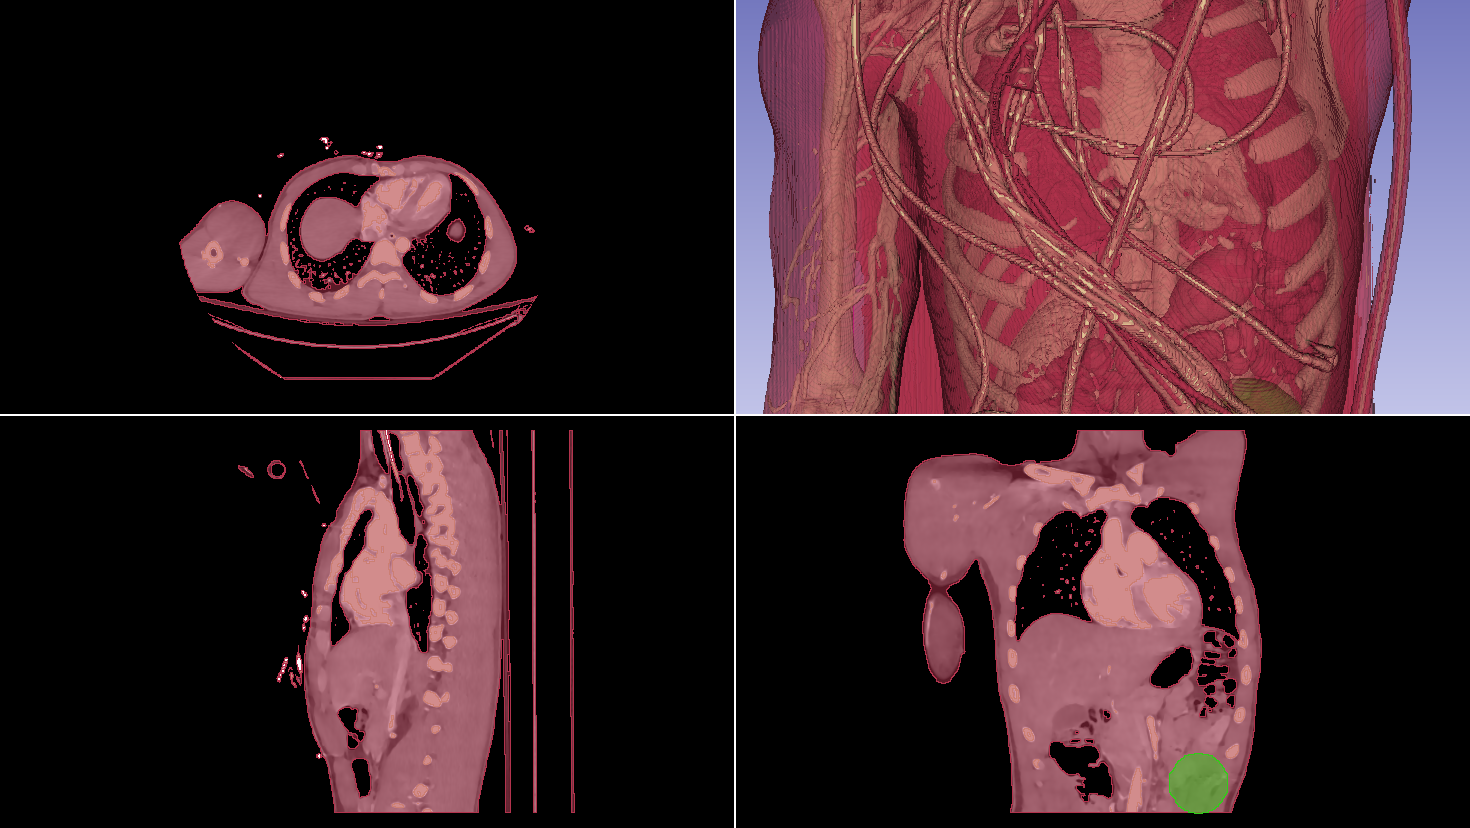

In [5]:
# Load input volume
slicer.mrmlScene.Clear()
import SampleData
volume=SampleData.SampleDataLogic().downloadCTACardio()

# Create segmentation using thresholding
slicer.util.selectModule("SegmentEditor")
segmentEditorWidget = slicer.modules.segmenteditor.widgetRepresentation().self().editor
segmentEditorNode = segmentEditorWidget.mrmlSegmentEditorNode()
segmentEditorNode.SetOverwriteMode(segmentEditorNode.OverwriteNone)

segmentationNode=slicer.mrmlScene.GetFirstNodeByClass("vtkMRMLSegmentationNode")
if not segmentationNode:
    segmentationNode = slicer.mrmlScene.AddNewNodeByClass("vtkMRMLSegmentationNode")
segmentEditorWidget.setSegmentationNode(segmentationNode)
segmentEditorWidget.setMasterVolumeNode(volume)
segmentationNode.GetSegmentation().RemoveAllSegments()

# Add bone segment
segmentID = segmentationNode.GetSegmentation().AddEmptySegment("bone")
segmentationNode.GetSegmentation().GetSegment(segmentID).SetColor(0.9, 0.8, 0.6)
segmentEditorNode.SetSelectedSegmentID(segmentID)
segmentEditorWidget.setActiveEffectByName("Threshold")
effect = segmentEditorWidget.activeEffect()
effect.setParameter("MinimumThreshold", 220)
effect.setParameter("MaximumThreshold", 2000)
effect.self().onApply()

# Add body segment
segmentID = segmentationNode.GetSegmentation().AddEmptySegment("body")
segmentEditorNode.SetSelectedSegmentID(segmentID)
segmentationNode.GetSegmentation().GetSegment(segmentID).SetColor(0.7, 0.2, 0.3)
segmentEditorWidget.setActiveEffectByName("Threshold")
effect = segmentEditorWidget.activeEffect()
effect.setParameter("MinimumThreshold", -500)
effect.setParameter("MaximumThreshold", 2000)
effect.self().onApply()

# Add a sphere-shaped segment
sphereSource = vtk.vtkSphereSource()
sphereSource.SetCenter(-100, -30, -170)
sphereSource.SetRadius(45)
sphereSource.SetThetaResolution(20)
sphereSource.Update()
segmentationNode.AddSegmentFromClosedSurfaceRepresentation(sphereSource.GetOutput(), "sphere", [0.2,0.8,0.1])

# Show results
segmentationNode.GetSegmentation().SetConversionParameter('Smoothing factor','0.0') # disable 3D smoothing
segmentationNode.CreateClosedSurfaceRepresentation() # show segmentation in 3D
segmentationNode.GetDisplayNode().SetOpacity3D(0.5)
volume.GetDisplayNode().AutoWindowLevelOff()
volume.GetDisplayNode().SetWindowLevel(420,30)
slicer.nb.displayViews("FourUp")

In [6]:
# Interactive slice view
@interact(position=(0,100))
def update(position=50):
    return slicer.nb.displaySliceView('Red', positionPercent=position)

interactive(children=(IntSlider(value=50, description='position'), Output()), _dom_classes=('widget-interact',…

In [ ]:
# Export segmentation to models
shNode = slicer.mrmlScene.GetSubjectHierarchyNode()
exportFolderItemId = shNode.CreateFolderItem(shNode.GetSceneItemID(), "Segments")
slicer.modules.segmentations.logic().ExportAllSegmentsToModels(segmentationNode, exportFolderItemId)

# Simplify models (this takes a while)
modelNodes = vtk.vtkCollection()
shNode.GetDataNodesInBranch(exportFolderItemId, modelNodes)
geometries = []
opacities = []
for modelNode in modelNodes:
    decimate = vtk.vtkQuadricDecimation()
    decimate.SetTargetReduction(0.9)
    decimate.SetInputData(modelNode.GetPolyData())
    decimate.Update()
    geometries.append(decimate.GetOutput())
    #geometries.append(modelNode.GetPolyData())
    opacities.append(0.4)

# Display models
view(geometries=geometries, ui_collapsed=True, geometry_opacities=opacities)

# Processing using CLI module

In [ ]:
# Load input volume
slicer.mrmlScene.Clear()
import SampleData
volume=SampleData.SampleDataLogic().downloadCTACardio()

# Interactive CLI module execution (with progress reporting)
parameters = {}
parameters["InputVolume"] = volume.GetID()
parameters["Threshold"] = 220
outModel = slicer.vtkMRMLModelNode()
slicer.mrmlScene.AddNode( outModel )
parameters["OutputGeometry"] = outModel.GetID()
grayMaker = slicer.modules.grayscalemodelmaker
print("Creating mesh from volume...")
slicer.nb.cliRunSync(grayMaker, None, parameters)

#view(geometries=outModel.GetPolyData(), ui_collapsed=True)

# Set CLI module parameters using interactive widget
from ipywidgets import interact_manual
v=view(geometries=outModel.GetPolyData(), ui_collapsed=True)
display(v)
@interact_manual(threshold=(-500.0,1200,5))
def update(threshold=parameters["Threshold"]):
    parameters["Threshold"] = threshold
    slicer.nb.cliRunSync(grayMaker, None, parameters)
    v.geometries=outModel.GetPolyData()
    return

In [ ]:
# Download created model
outputFile = "segmented-model.stl"
slicer.util.saveNode(outModel, slicer.nb.localPath(outputFile))
from IPython.display import FileLink
FileLink(outputFile)